# Run FlowSOM for pixel and cell clustering

In [1]:
%load_ext autoreload
%autoreload 2

import harpy as hp
from harpy.datasets import pixie_example
from harpy.utils._keys import ClusteringKey

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


## 1. Load example dataset

In [2]:
sdata = pixie_example(["fov0", "fov1"])
sdata

/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-15 14:30:42,646 - harpy.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2025-01-15 14:30:42,718 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov0'
2025-01-15 14:30:42,720 - harpy.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2025-01-15 14:30:42,724 - harpy.image._manager - INFO - Writing results to layer 'label_nuclear_fov0'
2025-01-15 14:30:42,726 - harpy.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2025-01-15 14:30:42,730 - harpy.image._manager - INFO - Writing resu

/Users/arnedf/.cache/huggingface/datasets/downloads/extracted/ed276a09a07145a5c25cd3c0a3fd99368fc2f3387300f55927c0b600c043de39/post_clustering


2025-01-15 14:30:42,845 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov1'
2025-01-15 14:30:42,847 - harpy.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2025-01-15 14:30:42,852 - harpy.image._manager - INFO - Writing results to layer 'label_nuclear_fov1'
2025-01-15 14:30:42,854 - harpy.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2025-01-15 14:30:42,859 - harpy.image._manager - INFO - Writing results to layer 'label_whole_fov1'
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/models/models.py:1046: ImplicitModificationWarning: Trying to modify attribute `._uns` 

SpatialData object
├── Images
│     ├── 'raw_image_fov0': DataArray[cyx] (22, 512, 512)
│     └── 'raw_image_fov1': DataArray[cyx] (22, 1024, 1024)
├── Labels
│     ├── 'label_nuclear_fov0': DataArray[yx] (512, 512)
│     ├── 'label_nuclear_fov1': DataArray[yx] (1024, 1024)
│     ├── 'label_whole_fov0': DataArray[yx] (512, 512)
│     └── 'label_whole_fov1': DataArray[yx] (1024, 1024)
└── Tables
      └── 'table': AnnData (1414, 22)
with coordinate systems:
    ▸ 'fov0', with elements:
        raw_image_fov0 (Images), label_nuclear_fov0 (Labels), label_whole_fov0 (Labels)
    ▸ 'fov1', with elements:
        raw_image_fov1 (Images), label_nuclear_fov1 (Labels), label_whole_fov1 (Labels)

In [3]:
channels = [
    "CD3",
    "CD4",
    "CD8",
    "CD14",
    "CD20",
    "CD31",
    "CD45",
    "CD68",
    "CD163",
    "CK17",
    "Collagen1",
    "Fibronectin",
    "ECAD",
    "HLADR",
    "SMA",
    "Vim",
]

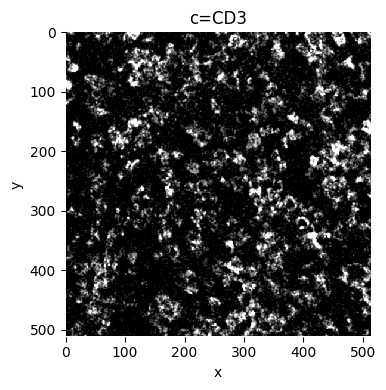

In [4]:
hp.pl.plot_image( sdata, img_layer="raw_image_fov0", to_coordinate_system="fov0", channel="CD3", figsize=(4,4) )

<Axes: title={'center': 'CD3'}, xlabel='Intensity', ylabel='Frequency'>

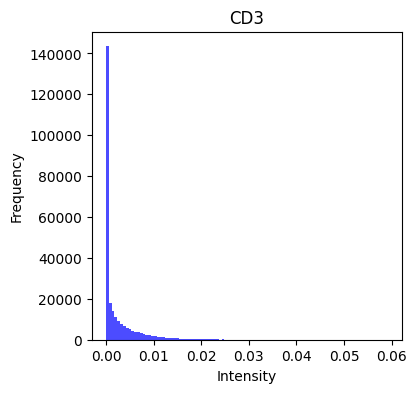

In [5]:
hp.pl.histogram(
    sdata,
    img_layer="raw_image_fov0",
    channel="CD3",
    bins=100,
    fig_kwargs={ "figsize": (4,4),  }
    )

## 2. Preprocess

In [6]:
sdata = hp.im.pixel_clustering_preprocess(
    sdata,
    img_layer=["raw_image_fov0", "raw_image_fov1"],
    output_layer=["raw_image_fov0_processed", "raw_image_fov1_processed"],
    channels=channels,
    chunks=2048,
    persist_intermediate=True, # set to False if you have multiple images, and if they are large.
    overwrite=True,
    sigma=2.0,
)

2025-01-15 14:30:44,631 - harpy.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2025-01-15 14:30:44,637 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov0_processed'
2025-01-15 14:30:44,638 - harpy.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2025-01-15 14:30:44,644 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov1_processed'


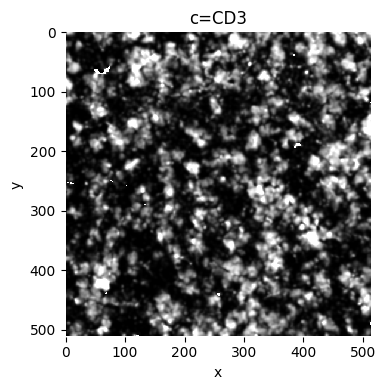

In [7]:
hp.pl.plot_image( sdata, img_layer="raw_image_fov0_processed", to_coordinate_system="fov0", channel="CD3", figsize=(4,4) )

<Axes: title={'center': 'CD3'}, xlabel='Intensity', ylabel='Frequency'>

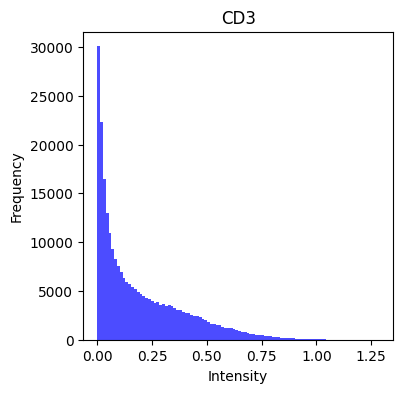

In [8]:
hp.pl.histogram(
    sdata,
    img_layer="raw_image_fov0_processed",
    channel="CD3",
    bins=100,
    fig_kwargs={ "figsize": (4,4),  }
    )

## 3. Pixel clustering

In [9]:
import flowsom as fs
from dask.distributed import Client, LocalCluster

work_with_client = False

if work_with_client:
    # client example
    cluster = LocalCluster(
        n_workers=1,
        threads_per_worker=10,
    )

    client = Client(cluster)
else:
    client = None

batch_model=fs.models.BatchFlowSOMEstimator

sdata, fsom, mapping = hp.im.flowsom(
    sdata,
    img_layer=[ "raw_image_fov0_processed", "raw_image_fov1_processed" ],
    output_layer_clusters=[
        "raw_image_fov0_flowsom_clusters",
        "raw_image_fov1_flowsom_clusters",
    ],  # we need output_cluster_layer and output_meta_cluster_layer --> these will both be labels layers
    output_layer_metaclusters=[
        "raw_image_fov0_flowsom_metaclusters",
        "raw_image_fov1_flowsom_metaclusters",
        ],
    n_clusters=20,
    random_state=111,
    chunks=512,
    client = client,
    model = batch_model,
    num_batches = 10,
    xdim=10,
    ydim=10,
    z_score=True,
    z_cap=3,
    persist_intermediate=True,
    overwrite=True,
)

2025-01-15 14:30:44,928 - harpy.image.pixel_clustering._clustering - INFO - Extracting random sample for FlowSOM training.
2025-01-15 14:30:45,065 - harpy.image.pixel_clustering._clustering - INFO - Start FlowSOM training.
2025-01-15 14:30:45.070 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2025-01-15 14:30:45.071 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2025-01-15 14:30:47.089 | DEBUG    | flowsom.main:__init__:88 - Updating derived values.
2025-01-15 14:30:47,403 - harpy.image.pixel_clustering._clustering - INFO - Finished FlowSOM training. Starting inference 
2025-01-15 14:30:47,737 - harpy.image._manager - WARNING - No dims parameter specified. Assuming order of dimension of provided array is ((c), (z), y, x)
2025-01-15 14:30:47,740 - harpy.image._manager - INFO - Writing results to layer 'raw_image_fov0_flowsom_clusters'
2025-01-15 14:30:47,740 - harpy.image._manager - WARNING - No dims parameter specified. Assuming order of d

In [10]:
sdata = hp.tb.cluster_intensity(
    sdata,
    mapping=mapping,
    img_layer=["raw_image_fov0_processed", "raw_image_fov1_processed"],
    labels_layer=["raw_image_fov0_flowsom_clusters", "raw_image_fov1_flowsom_clusters"],
    to_coordinate_system=[ "fov0", "fov1" ],
    output_layer="counts_clusters",
    overwrite=True,
)

2025-01-15 14:30:48,104 - harpy.table.pixel_clustering._cluster_intensity - INFO - Start allocation of intensities of image layer with name 'raw_image_fov0_processed' by labels in labels layer with name 'raw_image_fov0_flowsom_clusters'.
/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:217: ImplicitModificationWarning: Setting element `.obsm['spatial']` of view, initializing view as actual.
  adata.obsm[_SPATIAL] = coordinates
2025-01-15 14:30:48,625 - harpy.table.pixel_clustering._cluster_intensity - INFO - End allocation of image layer with name 'raw_image_fov0_processed' and labels layer with name 'raw_image_fov0_flowsom_clusters'.
2025-01-15 14:30:48,634 - harpy.table.pixel_clustering._cluster_intensity - INFO - Start allocation of intensities of image layer with name 'raw_image_fov1_processed' by labels in labels layer with name 'raw_image_fov1_flowsom_clusters'.
/Users/arnedf/VIB/harpy/src/harpy/table/_allocation_intensity.py:217: ImplicitModificationWarning: Sett

## 4. Visualization of pixel clusters and metaclusters

INFO     Dropping coordinate system 'fov1' since it doesn't have relevant elements.                                


/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:777: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


INFO     Dropping coordinate system 'fov1' since it doesn't have relevant elements.                                


/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:777: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


<Axes: title={'center': 'fov0'}>

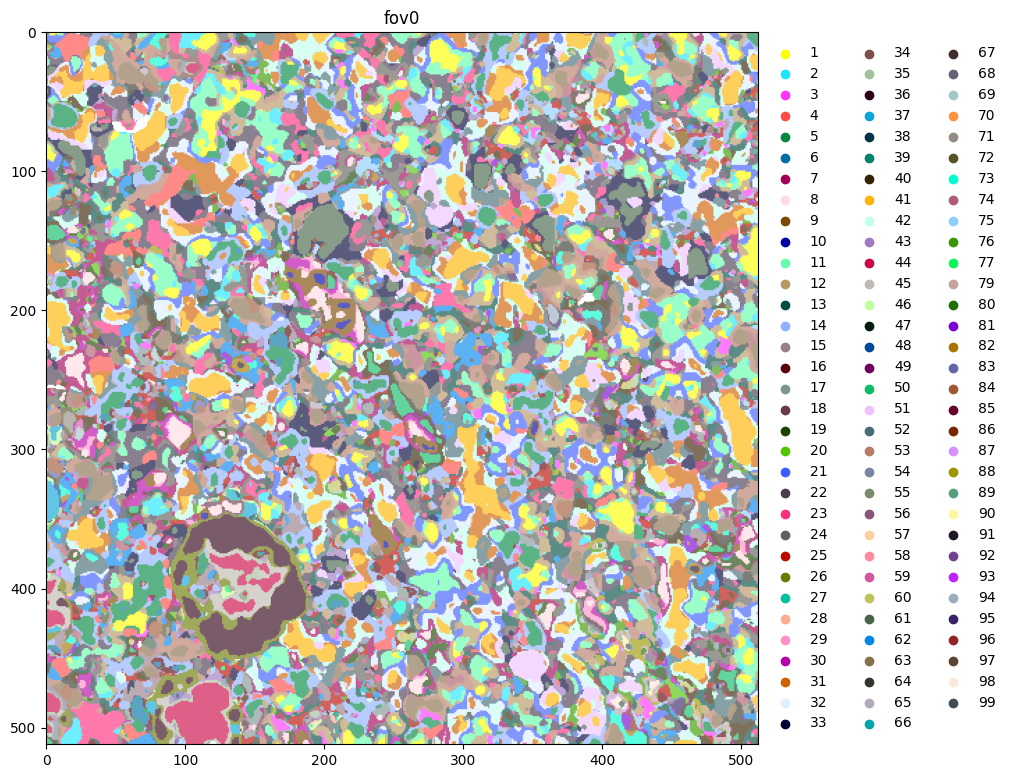

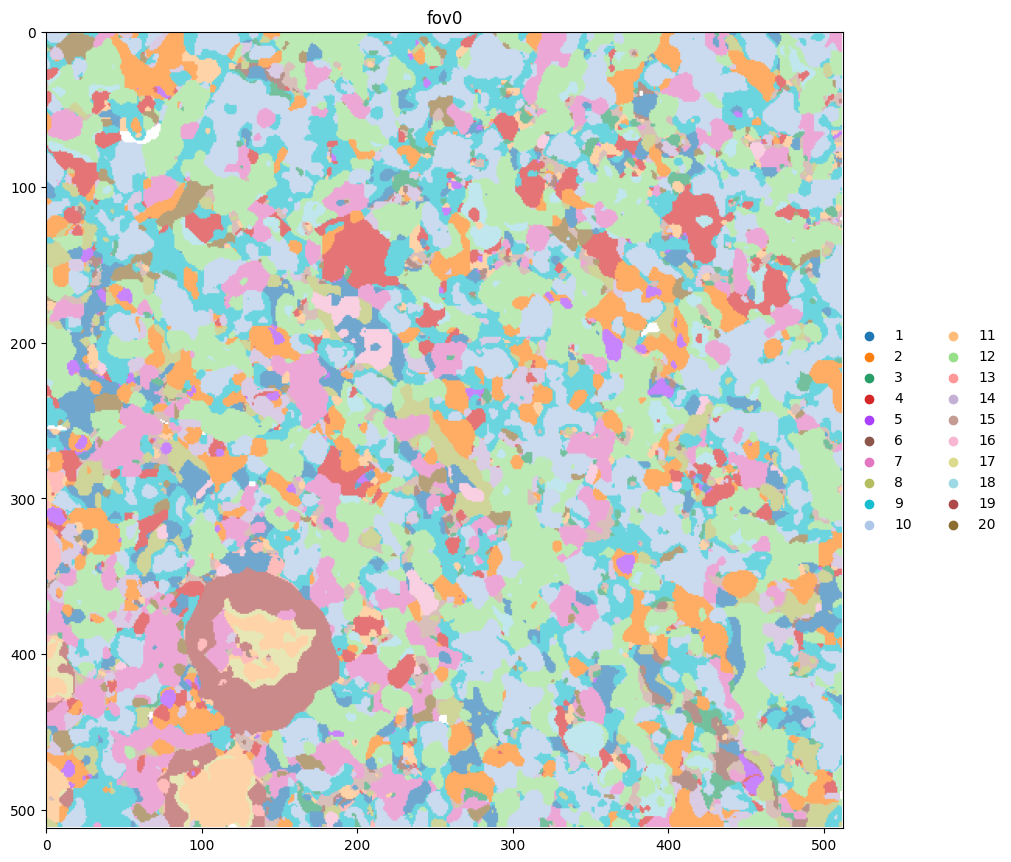

In [11]:
hp.pl.pixel_clusters(
    sdata,
    labels_layer="raw_image_fov0_flowsom_clusters",
    figsize=(10, 10),
    to_coordinate_system="fov0",
    render_labels_kwargs={ "alpha":1 }
)

hp.pl.pixel_clusters(
    sdata,
    labels_layer="raw_image_fov0_flowsom_metaclusters",
    figsize=(10, 10),
    to_coordinate_system="fov0",
    render_labels_kwargs={ "alpha":1 }
)

## 5. Heatmap of channel intensity per cluster and metacluster

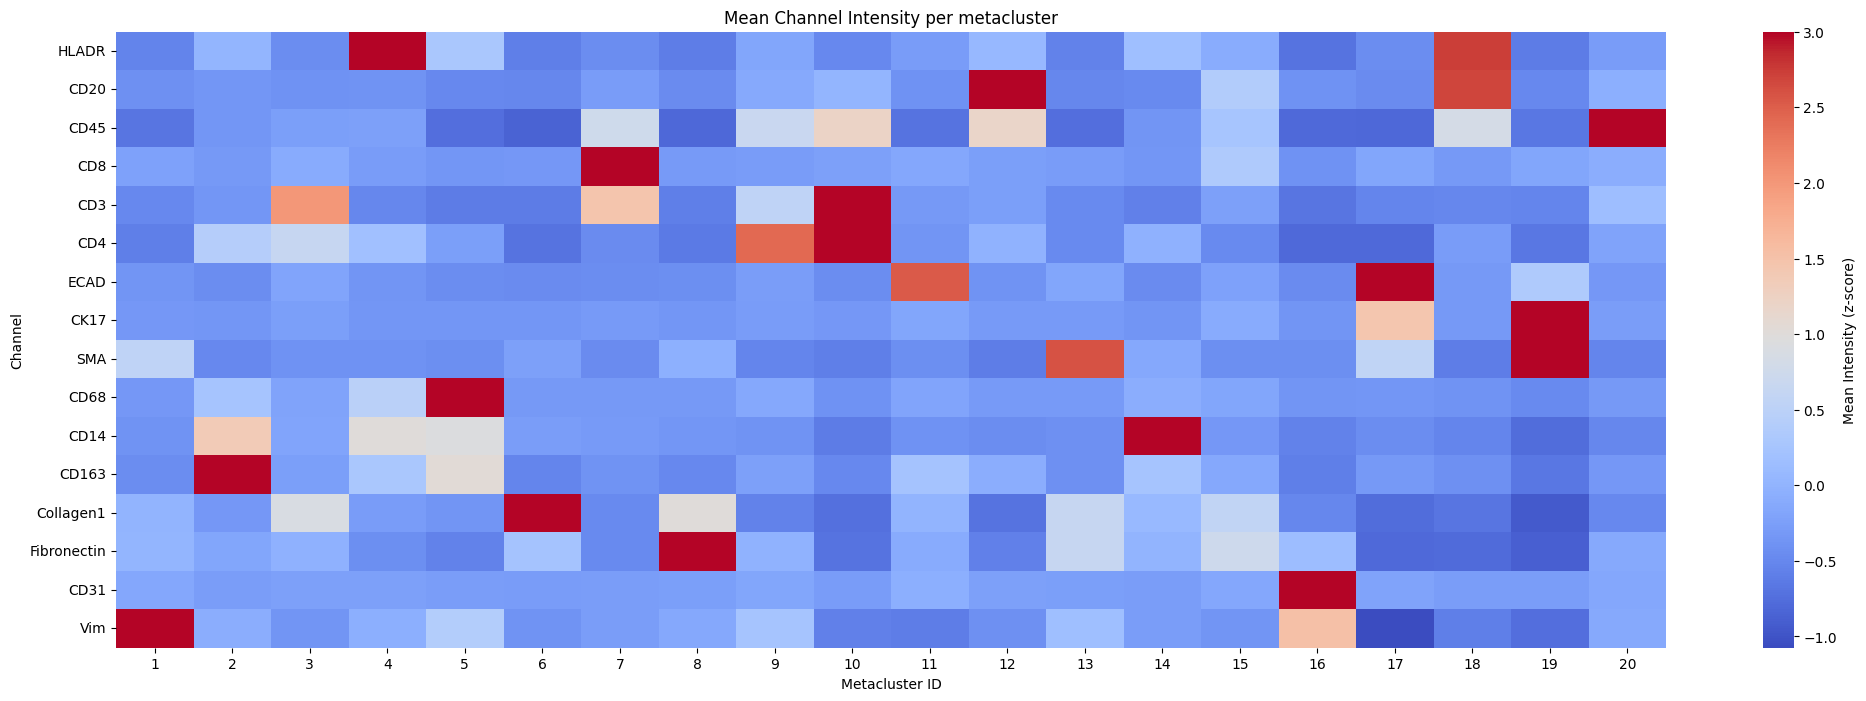

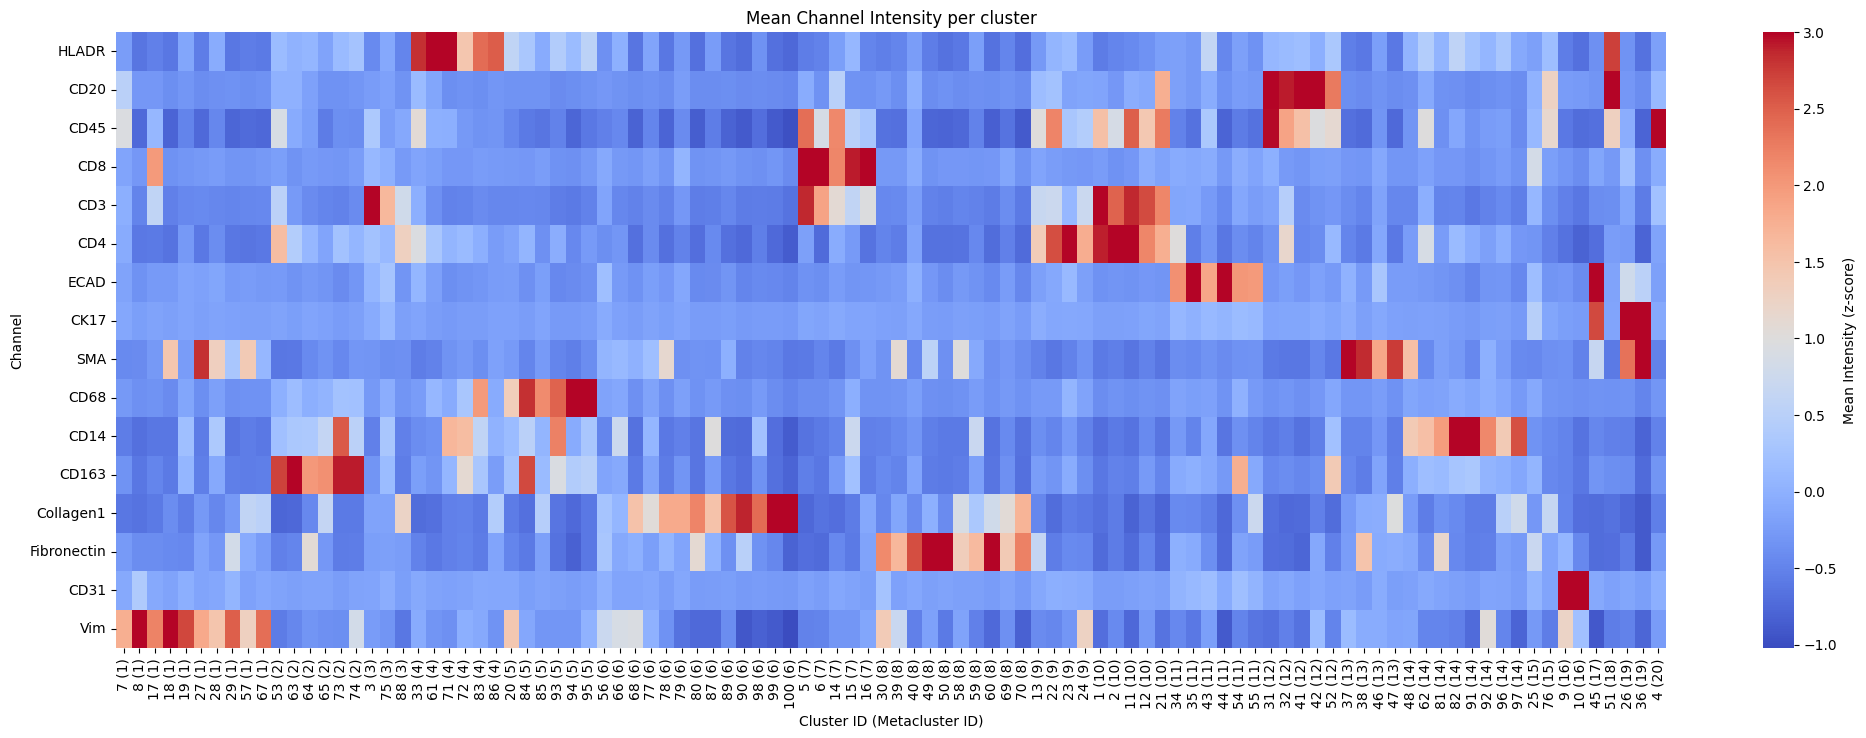

In [12]:
for _metaclusters in [True, False]:
    hp.pl.pixel_clusters_heatmap(
        sdata,
        table_layer="counts_clusters",
        figsize=(25, 8),
        fig_kwargs={"dpi": 100},
        linewidths=0.001,
        metaclusters=_metaclusters,
        z_score=True,
    )

## 6. Cell clustering

In [13]:
batch_model=fs.models.BatchFlowSOMEstimator

sdata, fsom = hp.tb.flowsom(
    sdata,
    labels_layer_cells=["label_whole_fov0", "label_whole_fov1"],
    labels_layer_clusters=[
        "raw_image_fov0_flowsom_metaclusters",
        "raw_image_fov1_flowsom_metaclusters",
    ],  # here you could also choose "ark_pixel_som_cluster"
    output_layer="table_cell_clustering_flowsom",
    chunks=512,
    model = batch_model,
    num_batches = 10,
    random_state=100,
    overwrite=True,
)

2025-01-15 14:30:52,860 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'label_whole_fov0'
2025-01-15 14:30:52,876 - harpy.table._preprocess - INFO - Calculating cell size from provided labels_layer 'label_whole_fov1'
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/models/models.py:1048: UserWarning: Converting `region_key: fov_labels` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/_core/_elements.py:124: UserWarning: Key `table_cell_clustering_flowsom` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
2025-01-15 14:30:52.921 | DEBUG    | flowsom.main:__init__:84 - Reading input.
2025-01-15 14:30:52.922 | DEBUG    | flowsom.main:__init__:86 - Fitting model: clustering and metaclustering.
2025-01-15 14:30:52.928 | DEBUG    | flowsom.main:__init__:88 - Updating derived value

INFO     Dropping coordinate system 'fov1' since it doesn't have relevant elements.                                


/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata_plot/pl/utils.py:777: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


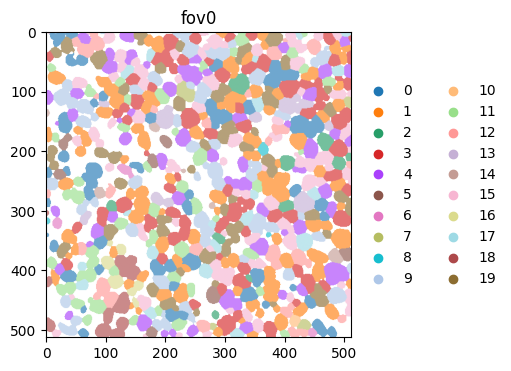

In [14]:
sdata.pl.render_labels("label_whole_fov0", table_name="table_cell_clustering_flowsom", color="metaclustering").pl.show( figsize=(5,5) )

In [15]:
# "table_cell_clustering_flowsom" is annotated by segmentation masks, so they can also be visualised using napari-spatialdata
sdata[ "table_cell_clustering_flowsom" ].uns[ "spatialdata_attrs" ]

#from napari_spatialdata import Interactive

#Interactive(sdata)

{'region': ['label_whole_fov0', 'label_whole_fov1'],
 'region_key': 'fov_labels',
 'instance_key': 'cell_ID'}

## Optional export to a .csv format that can be used for visualization using the ark analysis [gui](https://github.com/angelolab/ark-analysis/blob/main/templates/2_Pixie_Cluster_Pixels.ipynb)

In [16]:
# weighted channel average for visualization -> calculate this on the flowsom clustered matrix
sdata = hp.tb.weighted_channel_expression(
    sdata,
    table_layer_cell_clustering="table_cell_clustering_flowsom",
    table_layer_pixel_cluster_intensity="counts_clusters",
    output_layer="table_cell_clustering_flowsom",
    clustering_key=ClusteringKey._METACLUSTERING_KEY,
    overwrite=True,
)

2025-01-15 14:30:53,542 - harpy.table.cell_clustering._weighted_channel_expression - INFO - Adding mean over obtained cell clusters '(clustering)' of the average marker expression for each cell weighted by pixel cluster count to '.uns[ 'clustering_channels' ]' of table layer 'table_cell_clustering_flowsom'
2025-01-15 14:30:53,546 - harpy.table.cell_clustering._weighted_channel_expression - INFO - Adding mean over obtained cell clusters '(metaclustering)' of the average marker expression for each cell weighted by pixel cluster count to '.uns[ 'metaclustering_channels' ]' of table layer 'table_cell_clustering_flowsom'
2025-01-15 14:30:53,551 - harpy.table.cell_clustering._weighted_channel_expression - INFO - Adding average marker expression for each cell weighted by pixel cluster count to '.obs' of table layer 'table_cell_clustering_flowsom'
/Users/arnedf/miniconda3/envs/harpy/lib/python3.10/site-packages/spatialdata/_core/_elements.py:124: UserWarning: Key `table_cell_clustering_flowsom

In [17]:
from harpy.table.cell_clustering._utils import _export_to_ark_format as _export_to_ark_format_cells
from harpy.table.pixel_clustering._cluster_intensity import _export_to_ark_format as _export_to_ark_format_pixels

df = _export_to_ark_format_pixels(adata=sdata["counts_clusters"], output=None)
(
    df_cell_som_cluster_count_avg,
    df_cell_som_cluster_channel_avg,
    df_cell_meta_cluster_channel_avg,
) = _export_to_ark_format_cells(sdata, table_layer="table_cell_clustering_flowsom", output=None)
df.head()

2025-01-15 14:30:53,635 - harpy.table.cell_clustering._utils - WARNING - Increasing cell cluster IDs (SOM cluster and meta cluster IDs) with +1 for visualization. The underlying dataframe in the SpatialData object remains unchanges.
2025-01-15 14:30:53,639 - harpy.table.cell_clustering._utils - WARNING - Increasing cell cluster IDs (SOM cluster and meta cluster IDs) with +1 for visualization. The underlying dataframe in the SpatialData object remains unchanges.
2025-01-15 14:30:53,642 - harpy.table.cell_clustering._utils - WARNING - Increasing cell cluster IDs (SOM cluster and meta cluster IDs) with +1 for visualization. The underlying dataframe in the SpatialData object remains unchanges.


channels,CD3,CD4,CD8,CD14,CD20,CD31,CD45,CD68,CD163,CK17,Collagen1,Fibronectin,ECAD,HLADR,SMA,Vim,pixel_meta_cluster,pixel_som_cluster,count
cells,,,,,,,,,,,,,,,,,,,
1_counts_clusters_54606eef,79.662205,55.991234,3.339938,4.108338,3.976343,0.578644,40.246395,1.907112,2.754490,1.733413,7.401993,4.566187,2.153363,2.462132,1.229484,5.993419,10,1,11752
2_counts_clusters_54606eef,44.357776,78.521997,1.993199,6.019438,2.279956,0.575271,29.573188,2.653170,4.149742,1.820865,9.875389,6.779230,2.466204,3.465180,1.839119,9.828461,10,2,9440
3_counts_clusters_54606eef,60.862157,17.323038,7.604455,6.990412,2.871016,1.422096,21.476851,3.547263,6.289704,3.325128,19.664543,12.088449,7.148716,3.925060,5.011668,12.711450,3,3,7020
4_counts_clusters_54606eef,13.080275,11.272689,5.681579,7.350961,7.338359,2.766095,79.544518,3.125768,6.229959,3.226597,10.637938,11.225132,3.957128,6.422467,2.363766,12.759784,20,4,7375
5_counts_clusters_54606eef,49.938381,10.921948,49.406746,4.959634,5.208744,1.200178,53.361240,1.872839,3.809860,2.536913,5.482853,5.099018,2.056258,2.575106,1.056300,8.767088,7,5,11025


In [18]:
df_cell_meta_cluster_channel_avg.head()

channels,cell_meta_cluster,CD3,CD4,CD8,CD14,CD20,CD31,CD45,CD68,CD163,CK17,Collagen1,Fibronectin,ECAD,HLADR,SMA,Vim,cell_meta_cluster_rename
0,1,6.299169,8.121844,5.358722,10.315080,4.926896,2.307166,13.637037,4.833759,6.315595,2.176213,15.319963,9.489465,4.655840,6.311896,5.364626,10.953078,1
1,2,10.798331,15.966326,6.363395,11.135768,30.141203,3.715498,32.722422,4.233828,9.026940,4.662571,11.488077,9.472537,4.597014,11.514612,4.448869,12.693690,2
2,3,24.009645,29.893713,5.931200,14.955531,6.861588,2.075213,26.298962,6.266462,13.729800,2.233030,15.739620,11.327534,3.615646,8.896667,3.744496,12.556484,3
3,4,22.780092,29.580014,7.248573,9.638157,21.597594,1.771188,36.809714,3.854347,8.330138,2.622272,10.039929,8.659593,3.828098,8.615738,2.693399,12.327360,4
4,5,31.335387,39.304610,5.570846,11.028049,8.470510,1.781985,34.728856,3.881587,8.283615,2.437553,11.365455,9.686844,3.669731,6.331829,3.146310,12.405748,5
